## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
#torch.cuda.set_device(CUDA_VISIBLE_DEVICES)

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels'),
 PosixPath('/home/jupyter/.fastai/data/camvid/codes.txt')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [5]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/images/0006R0_f03420.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_08079.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_05070.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_04920_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0001TP_009480_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_07050_P.png')]

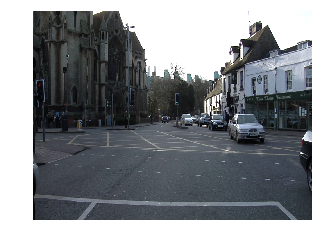

In [7]:
img_f = fnames[2]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

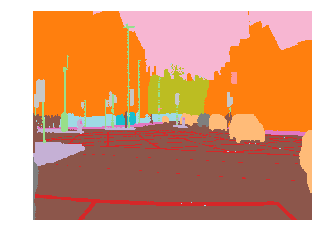

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [22, 22, 22,  ..., 17, 17, 17],
          [22, 22, 22,  ..., 17, 17, 17],
          [22, 22, 22,  ..., 17, 17, 17]]]))

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [20]:
size = src_size//2
bs=4

In [12]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [31]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

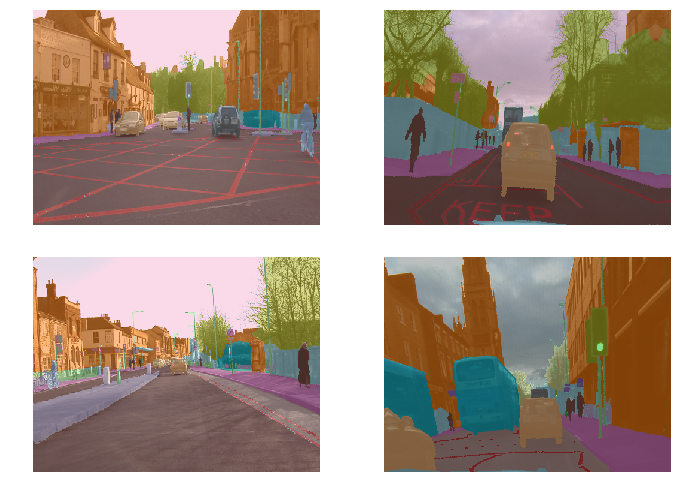

In [22]:
data.show_batch(2, figsize=(10,7))

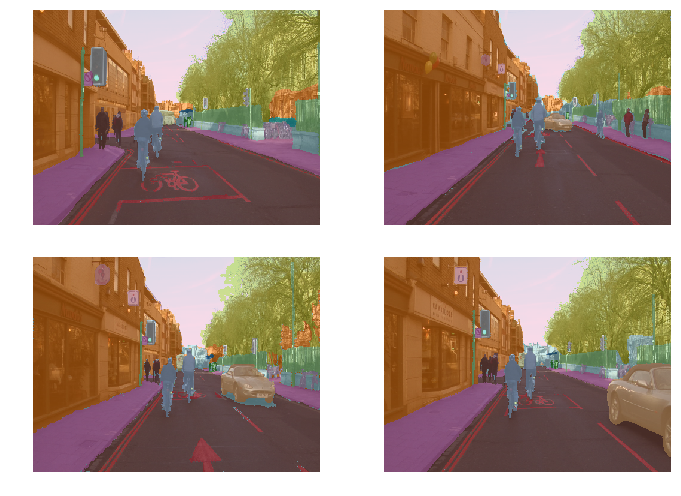

In [23]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [16]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [17]:
metrics=acc_camvid
# metrics=accuracy

In [19]:
wd=1e-2

In [33]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


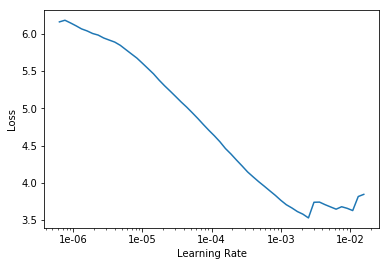

In [34]:
lr_find(learn)
learn.recorder.plot()

In [35]:
lr=1e-3

In [36]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid
1,1.138601,0.811100,0.814465
2,0.756547,0.729160,0.814589
3,0.647575,0.523319,0.865249
4,0.615438,0.531754,0.852259
5,0.584048,0.526178,0.842633
6,0.545129,0.416215,0.887065
7,0.520023,0.362082,0.899031
8,0.508065,0.343849,0.911325
9,0.472216,0.363752,0.901408
10,0.378072,0.295550,0.910679


In [37]:
learn.save('stage-1')

In [45]:
learn.load('stage-1');

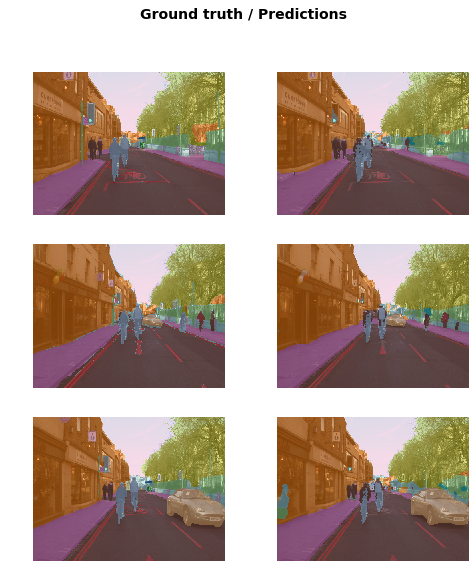

In [ ]:
learn.show_results(rows=3, figsize=(8,9))

In [46]:
learn.unfreeze()

In [47]:
lrs = slice(lr/400,lr/4)

In [48]:
doc(fit_one_cycle)

In [49]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.352375,0.293430,0.911563
2,0.327948,0.288587,0.913875
3,0.325256,0.282762,0.916842
4,0.319482,0.289832,0.914455
5,0.311246,0.291754,0.916471
6,0.295459,0.281221,0.916807
7,0.294396,0.277074,0.919912
8,0.283692,0.281551,0.918204
9,0.282160,0.294056,0.912733
10,0.270513,0.305676,0.912297


In [50]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [13]:
size = src_size
bs=2

In [14]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

use to_fp16() to save memory

In [20]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()

In [21]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


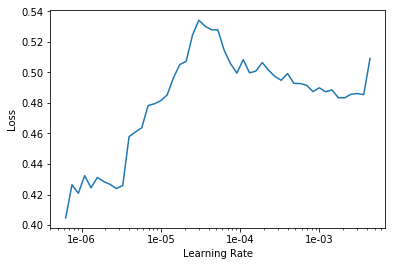

In [22]:
lr_find(learn)
learn.recorder.plot()

In [24]:
lr=1e-3

In [24]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.364661,0.307747,0.912986
2,0.318181,0.327175,0.909432
3,0.351918,0.309592,0.916170
4,0.365753,0.341782,0.905079
5,0.375406,0.293093,0.919514
6,0.379493,0.334371,0.903708
7,0.370411,0.312941,0.917631
8,0.374862,0.351528,0.902727
9,0.300678,0.283438,0.921847
10,0.246273,0.268414,0.927413


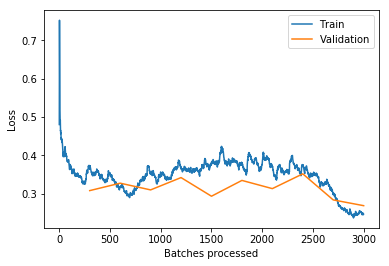

In [25]:
learn.recorder.plot_losses()

The loss increases at first and then decreases. This is the good sign.

In [27]:
learn.save('stage-1-big')

In [21]:
learn.load('stage-1-big');

In [22]:
learn.unfreeze()

In [25]:
lrs = slice(1e-6,lr/10)

In [28]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.232837,0.265724,0.928871
2,0.218860,0.249552,0.933547
3,0.207547,0.267210,0.930853
4,0.224082,0.246325,0.934147
5,0.205703,0.272458,0.929577
6,0.199848,0.274020,0.929769
7,0.191112,0.258519,0.931494
8,0.193586,0.259834,0.932235
9,0.183671,0.258435,0.932068
10,0.194207,0.257208,0.932368


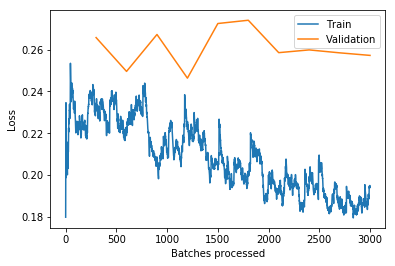

In [29]:
learn.recorder.plot_losses()

In [30]:
learn.save('stage-2-big')

In [31]:
learn.load('stage-2-big')

Learner(data=ImageDataBunch;

Train: LabelList
y: SegmentationLabelList (600 items)
[ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960)]...
Path: /home/jupyter/.fastai/data/camvid/images
x: SegmentationItemList (600 items)
[Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960)]...
Path: /home/jupyter/.fastai/data/camvid/images;

Valid: LabelList
y: SegmentationLabelList (101 items)
[ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960)]...
Path: /home/jupyter/.fastai/data/camvid/images
x: SegmentationItemList (101 items)
[Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960)]...
Path: /home/jupyter/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2

In [33]:
earn.data.valid_dl.add_tfm(to_half)learn.show_results(rows=3, figsize=(10,10))

RuntimeError: Input type (torch.cuda.HalfTensor) and weight type (torch.cuda.FloatTensor) should be the same

## fin